<a href="https://colab.research.google.com/github/niveousdragon/neuro_clustering/blob/main/Clustering_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Initialization { form-width: "300px" }
#!pip install spherecluster==0.1.7
#!pip install -U imbalanced-learn
#!pip install scikit-learn==0.24.0
#!pip install spherecluster==0.1.7
#from spherecluster import SphericalKMeans
from sklearn.cluster import KMeans
import numpy as np
import random
import matplotlib.pyplot as plt
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 17 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 2s (137 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 146425 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [2]:
#@title Spherical k-means patch { form-width: "300px" }
import warnings

import numpy as np
import scipy.sparse as sp
from joblib import Parallel, delayed

from sklearn.cluster import KMeans

# from sklearn.cluster import _k_means
from sklearn.cluster import _k_means_fast as _k_means
from sklearn.cluster.k_means_ import (
    _check_sample_weight,
    _init_centroids,
    _labels_inertia,
    _tolerance,
    _validate_center_shape,
)
from sklearn.preprocessing import normalize
from sklearn.utils import check_array, check_random_state
from sklearn.utils.extmath import row_norms, squared_norm
from sklearn.utils.validation import _num_samples


def _spherical_kmeans_single_lloyd(
    X,
    n_clusters,
    sample_weight=None,
    max_iter=300,
    init="k-means++",
    verbose=False,
    x_squared_norms=None,
    random_state=None,
    tol=1e-4,
    precompute_distances=True,
):
    """
    Modified from sklearn.cluster.k_means_.k_means_single_lloyd.
    """
    random_state = check_random_state(random_state)

    sample_weight = _check_sample_weight(sample_weight, X)

    best_labels, best_inertia, best_centers = None, None, None

    # init
    centers = _init_centroids(
        X, n_clusters, init, random_state=random_state, x_squared_norms=x_squared_norms
    )
    if verbose:
        print("Initialization complete")

    # Allocate memory to store the distances for each sample to its
    # closer center for reallocation in case of ties
    distances = np.zeros(shape=(X.shape[0],), dtype=X.dtype)

    # iterations
    for i in range(max_iter):
        centers_old = centers.copy()

        # labels assignment
        # TODO: _labels_inertia should be done with cosine distance
        #       since ||a - b|| = 2(1 - cos(a,b)) when a,b are unit normalized
        #       this doesn't really matter.
        labels, inertia = _labels_inertia(
            X,
            sample_weight,
            x_squared_norms,
            centers,
            precompute_distances=precompute_distances,
            distances=distances,
        )

        # computation of the means
        if sp.issparse(X):
            centers = _k_means._centers_sparse(
                X, sample_weight, labels, n_clusters, distances
            )
        else:
            centers = _k_means._centers_dense(
                X.astype(np.float),
                sample_weight.astype(np.float),
                labels,
                n_clusters,
                distances.astype(np.float),
            )

        # l2-normalize centers (this is the main contibution here)
        centers = normalize(centers)

        if verbose:
            print("Iteration %2d, inertia %.3f" % (i, inertia))

        if best_inertia is None or inertia < best_inertia:
            best_labels = labels.copy()
            best_centers = centers.copy()
            best_inertia = inertia

        center_shift_total = squared_norm(centers_old - centers)
        if center_shift_total <= tol:
            if verbose:
                print(
                    "Converged at iteration %d: "
                    "center shift %e within tolerance %e" % (i, center_shift_total, tol)
                )
            break

    if center_shift_total > 0:
        # rerun E-step in case of non-convergence so that predicted labels
        # match cluster centers
        best_labels, best_inertia = _labels_inertia(
            X,
            sample_weight,
            x_squared_norms,
            best_centers,
            precompute_distances=precompute_distances,
            distances=distances,
        )

    return best_labels, best_inertia, best_centers, i + 1


def spherical_k_means(
    X,
    n_clusters,
    sample_weight=None,
    init="k-means++",
    n_init=10,
    max_iter=300,
    verbose=False,
    tol=1e-4,
    random_state=None,
    copy_x=True,
    n_jobs=1,
    algorithm="auto",
    return_n_iter=False,
):
    """Modified from sklearn.cluster.k_means_.k_means.
    """
    if n_init <= 0:
        raise ValueError(
            "Invalid number of initializations."
            " n_init=%d must be bigger than zero." % n_init
        )
    random_state = check_random_state(random_state)

    if max_iter <= 0:
        raise ValueError(
            "Number of iterations should be a positive number,"
            " got %d instead" % max_iter
        )

    best_inertia = np.infty
    # avoid forcing order when copy_x=False
    order = "C" if copy_x else None
    X = check_array(
        X, accept_sparse="csr", dtype=[np.float64, np.float32], order=order, copy=copy_x
    )
    # verify that the number of samples given is larger than k
    if _num_samples(X) < n_clusters:
        raise ValueError(
            "n_samples=%d should be >= n_clusters=%d" % (_num_samples(X), n_clusters)
        )
    tol = _tolerance(X, tol)

    if hasattr(init, "__array__"):
        init = check_array(init, dtype=X.dtype.type, order="C", copy=True)
        _validate_center_shape(X, n_clusters, init)

        if n_init != 1:
            warnings.warn(
                "Explicit initial center position passed: "
                "performing only one init in k-means instead of n_init=%d" % n_init,
                RuntimeWarning,
                stacklevel=2,
            )
            n_init = 1

    # precompute squared norms of data points
    x_squared_norms = row_norms(X, squared=True)

    if n_jobs == 1:
        # For a single thread, less memory is needed if we just store one set
        # of the best results (as opposed to one set per run per thread).
        for it in range(n_init):
            # run a k-means once
            labels, inertia, centers, n_iter_ = _spherical_kmeans_single_lloyd(
                X,
                n_clusters,
                sample_weight,
                max_iter=max_iter,
                init=init,
                verbose=verbose,
                tol=tol,
                x_squared_norms=x_squared_norms,
                random_state=random_state,
            )

            # determine if these results are the best so far
            if best_inertia is None or inertia < best_inertia:
                best_labels = labels.copy()
                best_centers = centers.copy()
                best_inertia = inertia
                best_n_iter = n_iter_
    else:
        # parallelisation of k-means runs
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=0)(
            delayed(_spherical_kmeans_single_lloyd)(
                X,
                n_clusters,
                sample_weight,
                max_iter=max_iter,
                init=init,
                verbose=verbose,
                tol=tol,
                x_squared_norms=x_squared_norms,
                # Change seed to ensure variety
                random_state=seed,
            )
            for seed in seeds
        )

        # Get results with the lowest inertia
        labels, inertia, centers, n_iters = zip(*results)
        best = np.argmin(inertia)
        best_labels = labels[best]
        best_inertia = inertia[best]
        best_centers = centers[best]
        best_n_iter = n_iters[best]

    if return_n_iter:
        return best_centers, best_labels, best_inertia, best_n_iter
    else:
        return best_centers, best_labels, best_inertia


class SphericalKMeans(KMeans):
    """Spherical K-Means clustering
    Modfication of sklearn.cluster.KMeans where cluster centers are normalized
    (projected onto the sphere) in each iteration.
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    max_iter : int, default: 300
        Maximum number of iterations of the k-means algorithm for a
        single run.
    n_init : int, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
    init : {'k-means++', 'random' or an ndarray}
        Method for initialization, defaults to 'k-means++':
        'k-means++' : selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence. See section
        Notes in k_init for more details.
        'random': choose k observations (rows) at random from data for
        the initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centers.
    tol : float, default: 1e-4
        Relative tolerance with regards to inertia to declare convergence
    n_jobs : int
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For n_jobs below -1,
        (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one
        are used.
    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.
    verbose : int, default 0
        Verbosity mode.
    copy_x : boolean, default True
        When pre-computing distances it is more numerically accurate to center
        the data first.  If copy_x is True, then the original data is not
        modified.  If False, the original data is modified, and put back before
        the function returns, but small numerical differences may be introduced
        by subtracting and then adding the data mean.
    normalize : boolean, default True
        Normalize the input to have unnit norm.
    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Coordinates of cluster centers
    labels_ :
        Labels of each point
    inertia_ : float
        Sum of distances of samples to their closest cluster center.
    """

    def __init__(
        self,
        n_clusters=8,
        init="k-means++",
        n_init=10,
        max_iter=300,
        tol=1e-4,
        n_jobs=1,
        verbose=0,
        random_state=None,
        copy_x=True,
        normalize=True,
    ):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init
        self.verbose = verbose
        self.random_state = random_state
        self.copy_x = copy_x
        self.n_jobs = n_jobs
        self.normalize = normalize

    def fit(self, X, y=None, sample_weight=None):
        """Compute k-means clustering.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        y : Ignored
            not used, present here for API consistency by convention.
        sample_weight : array-like, shape (n_samples,), optional
            The weights for each observation in X. If None, all observations
            are assigned equal weight (default: None)
        """
        if self.normalize:
            X = normalize(X)

        random_state = check_random_state(self.random_state)

        # TODO: add check that all data is unit-normalized

        self.cluster_centers_, self.labels_, self.inertia_, self.n_iter_ = spherical_k_means(
            X,
            n_clusters=self.n_clusters,
            sample_weight=sample_weight,
            init=self.init,
            n_init=self.n_init,
            max_iter=self.max_iter,
            verbose=self.verbose,
            tol=self.tol,
            random_state=random_state,
            copy_x=self.copy_x,
            n_jobs=self.n_jobs,
            return_n_iter=True,
        )

        return self

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#@title Mouse class { form-width: "300px" }
import pandas as pd
import numpy as np
from scipy import interpolate, signal
import math
from scipy.stats import kstest
import copy

#from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

class Mouse():

    def __init__(self, name, session, day, time_shift, build_spikes, xc, yc,
                 path_track, path_neuro, path_spatial_info, **kwargs):
        
        self.name = name
        self.session = session
        self.day = day
        self.dtypef = np.float32
        self.time_shift = time_shift
        self.start_trim = 10
        self.end_trim = 10

        
        xy_delim = ' '
        xy_sk_rows = 1
        xy_sk_cols = 0
        if 'xy_delim' in kwargs:
            xy_delim = kwargs['xy_delim']    
        if 'xy_sk_rows' in kwargs:
            xy_sk_rows = kwargs['xy_sk_rows'] 
        if 'xy_sk_cols' in kwargs:
            xy_sk_cols = kwargs['xy_sk_cols']
             
        self.get_xy_data(path_track, path_neuro, xc, yc, xy_delim, xy_sk_rows, xy_sk_cols)
        
        if build_spikes:
            self.build_spikes()
        elif 'path_spikes' in kwargs:
            self.get_spike_data(kwargs['path_spikes'])       
        
        self.get_angle()
        self.trim_data()
        
        try:
            SI_data = pd.read_csv(path_spatial_info)
            #SI_data = SI_data.astype(object).replace(np.nan, 'None')

            self.spatial_info = SI_data['spatial_info'].values
            self.rand_spatial_info = SI_data['rand_spatial_info'].values
            self.rand_spatial_info_std = SI_data['rand_spatial_info_std'].values
            self.cell_z_score = np.array([np.nan for _ in range(self.n_cells)])
            for i in range(self.n_cells):
                try:
                    self.cell_z_score[i] = (self.spatial_info[i] - self.rand_spatial_info[i])/self.rand_spatial_info_std[i]
                except:
                    pass

        except:
        
            print('Spatial info data not found, calculating SI from scratch...')
            self.spatial_info = np.array([np.nan for _ in range(self.n_cells)])
            self.rand_spatial_info = np.array([np.nan for _ in range(self.n_cells)])
            self.rand_spatial_info_std = np.array([np.nan for _ in range(self.n_cells)])
        
    def get_xy_data(self, path_track, neuro_path, xc, yc, delimiter = ' ', skip_rows = 1, skip_cols = 0):
        w = 21
        time_massive = []
        x_massive = []
        y_massive = []
        self.x = []
        self.y = []
        self.v = []
        self.vx = []
        self.vy = []
        self.xc = xc
        self.yc = yc
       
        tr = np.genfromtxt(path_track, delimiter=delimiter, skip_header=skip_rows)
        time_massive = tr[:,0]
        x_massive = tr[:,1+skip_cols]
        y_massive = tr[:,2+skip_cols]
        
        #pre-filtering
        x_massive = signal.medfilt(x_massive, 11)
        y_massive = signal.medfilt(y_massive, 11)
        
        #removing NaN values
        valid_indices = ~np.isnan(x_massive) * ~np.isnan(y_massive)
        time_massive = time_massive[valid_indices]
        x_massive = x_massive[valid_indices]
        y_massive = y_massive[valid_indices] 

        #interp to 20 fps        
        fx = interpolate.interp1d(time_massive, x_massive)
        fy = interpolate.interp1d(time_massive, y_massive)
        self.time = list(range(int(time_massive[0]*20)+1, int(time_massive[-1]*20)))
        for i in range(len(self.time)):
            self.time[i] *= 0.05
            self.x.append(fx(self.time[i]))
            self.y.append(fy(self.time[i]))
        
        #smoothing with 1-s window average filter
        self.x = np.convolve(self.x, np.ones(w)/w, mode='same')
        self.y = np.convolve(self.y, np.ones(w)/w, mode='same')
        
        #speed
        for i in range(1, len(self.x)):
            self.v.append(round(np.sqrt((self.x[i] - self.x[i-1])**2 + (self.y[i] - self.y[i-1])**2)/(self.time[i]-self.time[i-1]), 3))
            self.vx.append(round((self.x[i] - self.x[i-1])/(self.time[i]-self.time[i-1]), 3))
            self.vy.append(round((self.y[i] - self.y[i-1])/(self.time[i]-self.time[i-1]), 3))
            
        self.min_time_trace = self.time[0]
        shift_sp_rows = int(round((self.min_time_trace - self.time_shift)*20))
        t_size = len(self.time)

        #neural activity
        neur = np.genfromtxt(neuro_path, delimiter=',', skip_header=shift_sp_rows, max_rows=t_size, dtype=self.dtypef, comments='None')
        self.neur = neur[:, 1:]
        
        self.n_cells = len(self.neur[0])
        self.n_frames = len(self.neur)
        self.pc_mask = None

        self.x = self.x[0:self.n_frames]
        self.y = self.y[0:self.n_frames] 

        self.scx = (self.x-min(self.x))/(max(self.x)-min(self.x))-0.000001
        self.scy = (self.y-min(self.y))/(max(self.y)-min(self.y))-0.000001

        if self.xc == None or self.yc == None:
            start = self.start_trim
            end = self.end_trim
            self.xc = (min(self.scx[start:-end])+max(self.scx[start:-end]))/2
            self.yc = (min(self.scy[start:-end])+max(self.scy[start:-end]))/2

        self.v = np.array(self.v[0:self.n_frames])
        self.vx = np.array(self.vx[0:self.n_frames])
        self.vy = np.array(self.vy[0:self.n_frames])
        self.time = np.array(self.time[0:self.n_frames])

    def get_spike_data(self, spike_path):
        shift_sp_rows = int(round((self.min_time_trace - self.time_shift)*20))
        t_size = len(self.time)
        sp = np.genfromtxt(spike_path, delimiter=',', skip_header=shift_sp_rows, max_rows=t_size, dtype=self.dtypef, comments='None')
        self.spikes = sp[:, 1:]
        self.smoothed_spikes = copy.deepcopy(self.spikes)
        self.spikes_count = np.sum(self.spikes.astype(bool).astype(int), axis = 0)
        '''
        for i in range(1,10):
            #print(sum(self.smoothed_spikes[:,0]))
            self.smoothed_spikes += np.roll(copy.deepcopy(self.spikes), i, axis=0)
        '''
    def build_spikes(self):
        pass

    def get_angle(self):
        self.angle = []
        xc, yc = self.xc, self.yc
        
        for i in range(len(self.scx)):
            self.angle.append(180 + round((math.degrees(math.atan2(self.scy[i] - yc, self.scx[i] - xc))),3))
        self.angle = np.array(self.angle)  

    def get_direction(self):
         der = np.ediff1d(self.angle, 0)
         der[der <= -90] += 360
         der[der >= 90] -= 360
         self.direction = np.sign(der)

    def get_acceleration(self):
        w = 35
        sp = np.convolve(self.v, np.ones(w)/w, mode='same')
        self.acceleration = np.gradient(sp, 0.05, edge_order=2)
        
    def get_binned_neuro(self, Nbins):
        self.neuro_bin = np.zeros(self.neur.shape, dtype = int)
        for i in range(self.neur.shape[1]):
            ma = np.max(self.neur[:,i])
            mi = np.min(self.neur[:,i])
            self.neuro_bin[:,i] = (self.neur[:,i] - mi)*Nbins/(ma-mi)
        self.neuro_bin[self.neuro_bin == Nbins] -= 1

    def get_shuffled_neuro(self, n):
        self.shuffled_neur = np.zeros(((self.n_frames//n)*n, self.n_cells))

        for i in range(self.n_cells):
            ts = self.neur[:,i]
            #chunks = np.concatenate((np.split(ts[:(len(ts)//n)*n], n), ts[(len(ts)//n)*n:]))
            chunks = np.split(ts[:(len(ts)//n)*n], n)
            inds = np.arange(n)
            np.random.shuffle(inds)

            self.shuffled_neur[:,i] = np.concatenate(tuple(np.array(chunks)[inds]))
            
    def trim_data(self):

        start = self.start_trim
        end = self.end_trim

        self.x = self.x[start:-end]
        self.y = self.y[start:-end]
        self.scx = self.scx[start:-end]
        self.scy = self.scy[start:-end]

        self.time = self.time[start:-end]
        self.v = self.v[start:-end]
        self.vx = self.vx[start:-end]
        self.vy = self.vy[start:-end]
        self.angle = self.angle[start:-end]

        self.spikes = self.spikes[start:-end]
        self.smoothed_spikes = self.smoothed_spikes[start:-end]
        self.neur = self.neur[start:-end]

    def trajectory(self, points = None, colors = None):
        fig, ax = plt.subplots(figsize = (12,12))
        if colors is None:
            colors = range(len(ms.scx))
        
        if points is None:
            ax.scatter(ms.scx, ms.scy, c = colors)
        else:
            ax.scatter(ms.scx[points], ms.scy[points], c = colors)

def TrimTime(Mouse, t_end):
    if  Mouse.n_frames >= int((t_end - Mouse.time[0])*20):   
        Mouse.n_frames = int((t_end - Mouse.time[0])*20)
    else:
        raise ValueError   
 
    fr_end = Mouse.n_frames - 1
    Mouse.time = Mouse.time[0:fr_end]
    Mouse.angle = Mouse.angle[0:fr_end]
    Mouse.spikes = Mouse.spikes[0:fr_end,:]
    Mouse.neur = Mouse.neur[0:fr_end,:]
    Mouse.neuro_bin = Mouse.neuro_bin[0:fr_end,:]
    return Mouse

def GetRears(Mouse, rear_fname):
    rr = np.genfromtxt(rear_fname, delimiter=',', skip_header=0)
    fr = interpolate.interp1d(rr[:,0], rr[:,1])
    Mouse.rear = [np.sign(fr(t)) for t in Mouse.time]
    return Mouse

def RearStat(Mouse, n_sup, cell):
    rear_t_inz = []
    n_spec = 0
    for i, ti in enumerate(Mouse.times_in[cell]):
        if (i==0 or i>=1 and Mouse.t_spec[n_sup][0] >= Mouse.times_out[cell][i-1])  and Mouse.t_spec[n_sup][0] <= Mouse.times_out[cell][i]:
            n_spec = i
        rear_t_inz.append(np.sum(np.abs(Mouse.rear[ti:Mouse.times_out[cell][i]]))/(Mouse.times_out[cell][i]-ti))
    if n_spec:
        rear_t_bef = sum(rear_t_inz[:n_spec])/n_spec
    else:
        rear_t_bef = 0   
    rear_t_aft = sum(rear_t_inz[n_spec:])/(len(rear_t_inz) - n_spec)
    return rear_t_inz, rear_t_bef, rear_t_aft
            

In [4]:
#@title Matrix models { form-width: "300px" }
def create_er(n, p, weighted = 0):
    if weighted:
        X = np.random.random(size=(n,n))
        has_edge = np.random.choice([0, 1], size=(n,n), p=[1 - p/2., p/2.])
        A = np.multiply(X, has_edge)
    else:
        A = np.random.choice([0, 1], size=(n,n), p=[1 - p/2., p/2.])

    A = np.tril(A) + np.tril(A, -1).T
    return A

def create_sbm(N, q, w_in = 0.9, w_out = 0.1, random_sizes = 0):
    
    a=np.zeros((N,N))

    if random_sizes:
        sizes_do_not_fit = 1
        while sizes_do_not_fit:
            starts = [0] + list(np.sort(np.random.randint(0, high = N, size = q)))
            sz = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
            if sum(np.array([s > N//(2*q) for s in sz]).astype(int)) == q:
                sizes_do_not_fit = 0

    else:
        sz=int(N/q)
        starts=[i*sz for i in range(q)]
    
    ends=np.r_[[starts[i]-1 for i in range(1,q)],[N-1]]

    for i in range(q):
        for j in range(i,q):
            if i==j:
                lm=w_in
            else:
                lm=w_out
    
            a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]=np.random.poisson(lm, size=np.shape(a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]))
            a[starts[j]:ends[j]+1, starts[i]:ends[i]+1]=a[starts[i]:ends[i]+1, starts[j]:ends[j]+1].T

            if i==j:
                a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]=(a[starts[i]:ends[i]+1, starts[j]:ends[j]+1]+a[starts[i]:ends[i]+1, starts[j]:ends[j]+1].T)/2
    return a


In [5]:
#@title Graph randomization { form-width: "300px" }

def turn_to_directed(mat, directed = 0.0, weighted = 0):

    if not isinstance(mat, np.ndarray):
        raise Exception('Wrong input parsed to turn_to_directed function!')
    
    A = copy.deepcopy(mat)
    if directed == 0.0:
        if not weighted:
            a = A.astype(bool)
        else:
            a = A.astype(float)
        return sp.csr_matrix(a)

    np.fill_diagonal(A, 0)
    rows, cols = A.nonzero()
    edgeset = set(zip(rows, cols))
    upper = np.array([l for l in edgeset if l[0]<l[1]])
    dircount = 0

    random_tosses = np.random.random(len(upper))
    condition1 = (random_tosses >= directed/2.0) & (random_tosses < directed)
    condition2 = (random_tosses <= directed/2.0) & (random_tosses < directed)
    indices_where_upper_is_removed = np.where(condition1 == True)[0]
    indices_where_lower_is_removed = np.where(condition2 == True)[0]

    
    u_xdata = [u[0] for u in upper[indices_where_upper_is_removed]]
    u_ydata = [u[1] for u in upper[indices_where_upper_is_removed]]
    A[u_xdata, u_ydata] = 0

    l_xdata = [u[1] for u in upper[indices_where_lower_is_removed]]
    l_ydata = [u[0] for u in upper[indices_where_lower_is_removed]]
    A[l_xdata, l_ydata] = 0

    a = sp.csr_matrix(A)
    #get_symmetry_index(a)
    return a

def symmetric_component(A, is_weighted):
    a = A.astype(bool).A
    symm_mask = np.bitwise_and(a, a.T)
    if not is_weighted:
        return symm_mask

    return np.multiply(symm_mask, A.A)

def non_symmetric_component(A, is_weighted):
    return A.astype(float) - symmetric_component(A, is_weighted).astype(float)


def adj_random_rewiring_iom_preserving(a, is_weighted, r=10):
    #print ('Rewiring double connections...')
 
    s = symmetric_component(a, is_weighted)
    #plt.matshow(s)
    rs = turn_to_directed(s, directed = 1.0, weighted = is_weighted)
    #plt.matshow(s)
    #plt.matshow(rs.A)
    rows, cols = rs.A.nonzero()
    edgeset = set(zip(rows, cols))
    upper = [l for l in edgeset]# if l[0]<l[1]]
    source_nodes = [e[0] for e in upper]
    target_nodes = [e[1] for e in upper]
 
    double_edges = len(upper)
 
    i=0
 
    while i < double_edges*r:
        if i>0 and i%10000 == 0:
            print(i)
    #while i < 1:
        good_choice = 0
        while not good_choice:
            ind1, ind2 = np.random.choice(double_edges, 2)
            n1, n3 = source_nodes[ind1], source_nodes[ind2]
            n2, n4 = target_nodes[ind1], target_nodes[ind2]
 
            if len(set([n1,n2,n3,n4])) == 4:
                good_choice = 1
        
        w1 = s[n1,n2]
        w2 = s[n2,n1] 
        w3 = s[n3,n4] 
        w4 = s[n4,n3] 

        if s[n1,n3] + s[n1,n4] + s[n2,n3] + s[n2,n4] == 0:
 
            s[n1,n4] = w1
            s[n4,n1] = w2
            s[n2,n3] = w3
            s[n3,n2] = w4
 
            s[n1,n2] = 0
            s[n2,n1] = 0
            s[n3,n4] = 0
            s[n4,n3] = 0
 
            target_nodes[ind1], target_nodes[ind2] = n4, n2
 
            i += 1
            #print(get_symmetry_index(sp.csr_matrix(A)))
 
    #plt.matshow(s)
    #print ('Rewiring single connections...')
 
    ns = non_symmetric_component(a, is_weighted)
 
    #plt.matshow(ns)
    rows, cols = ns.nonzero()
    edges = list((set(zip(rows, cols))))
    source_nodes = [e[0] for e in edges]
    target_nodes = [e[1] for e in edges]
    single_edges = len(edges)
 
    i=0
          
    while i < single_edges*r:
    #while i < 10:
        good_choice = 0
        while not good_choice:
            ind1, ind2 = np.random.choice(single_edges, 2)
            n1, n3 = source_nodes[ind1], source_nodes[ind2]
            n2, n4 = target_nodes[ind1], target_nodes[ind2]
 
            if len(set([n1,n2,n3,n4])) == 4:
                good_choice = 1
        
        w1 = ns[n1,n2]
        w2 = ns[n3,n4]
 
        checklist = [ns[n1,n3], ns[n1,n4], ns[n2,n3], ns[n2,n4],
                     ns[n3,n1], ns[n4,n1], ns[n3,n2], ns[n4,n2],
                     s[n3,n1], s[n4,n1], s[n3,n2], s[n4,n2]]
        
        if checklist.count(0) == 12:
 
            ns[n1,n4] = w1
            ns[n3,n2] = w2
 
            ns[n1,n2] = 0
            ns[n3,n4] = 0
 
            i += 1
 
            target_nodes[ind1], target_nodes[ind2] = n4, n2
            #print(get_symmetry_index(sp.csr_matrix(A)))
    
    res = s + ns
    if not is_weighted:
        res = res.astype(bool)
 
    return sp.csr_matrix(res)

In [6]:
#@title Plotting routines { form-width: "300px" }

def change_labels_color(ax):
    [t.set_color('white') for t in ax.xaxis.get_ticklines()]
    [t.set_color('white') for t in ax.xaxis.get_ticklabels()]
    [t.set_color('white') for t in ax.yaxis.get_ticklines()]
    [t.set_color('white') for t in ax.yaxis.get_ticklabels()]
    

def plot_mat(mat):
    fig, ax = plt.subplots(figsize = (12, 12))
    change_labels_color(ax)
    im = ax.imshow(mat)
    cbar = ax.figure.colorbar(im, ax=ax)

In [7]:
#@title K-means { form-width: "300px" }
import numpy as np
from sklearn.cluster import MiniBatchKMeans

class FaissKMeans():

    def __init__(self, n_clusters=8, n_init=10, max_iter=10,
                 spherical = True, verbose = True, seed = 42):
        
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.spherical = spherical
        self.verbose = verbose
        self.seed = seed
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X, y=None):
        kwargs = {'niter':self.max_iter,
                  'nredo':self.n_init}#,
                  #'spherical': self.spherical,
                  #'verbose': self.verbose,
                  #'seed': self.seed}

        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   **kwargs)
        
        #self.cp = faiss.ClusteringParameters(**kwargs)
        X = np.array(X.astype(np.float32), order='c')
        self.kmeans.train(X)

        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
        #print('computing labels...')
        self.labels_ = self.kmeans.index.search(x=X, k=1)[1].reshape(-1)

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]


def faiss_kmeans(vals, vecs, n_clusters, num_vecs):
    vecs_leading = vecs[:, np.argsort(vals)[1:num_vecs]]

    fskm = FaissKMeans(n_clusters=n_clusters,            
                       n_init=200,
                       max_iter=100,
                       spherical = 0,
                       verbose = 1,
                       seed = 42)

    # do the clustering
    fskm.fit(vecs_leading)
    labels = fskm.labels_

    # centers of clusters
    centers = fskm.cluster_centers_
    inertia = fskm.inertia_

    return labels, inertia, centers

def spherical_kmeans(vals, vecs, n_clusters, num_vecs):

    vecs_leading = vecs[:, np.argsort(vals)[1:num_vecs]]
    skm = SphericalKMeans(n_clusters=n_clusters,            
        init='k-means++',
        n_init=100,
        max_iter=10000,
        tol=0.00001,
        verbose=1,
        random_state=42,
        copy_x=True,
        n_jobs=32)

    # do the clustering
    skm.fit(vecs_leading)

    return skm.labels_, skm.inertia_, skm.cluster_centers_


def kmeans(vals, vecs, n_clusters, num_vecs):

    vecs_leading = vecs[:, np.argsort(vals)[1:num_vecs]]

    skm = KMeans(n_clusters=n_clusters,            
                init='k-means++',
                n_init=100,
                max_iter=1000,
                tol=0.00001,
                verbose=1,
                random_state=42,
                copy_x=True,
                n_jobs=32)

    # do the clustering
    skm.fit(vecs_leading)
    labels = skm.labels_

    # centers of clusters
    centers = skm.cluster_centers_

    return labels

def mini_batch_kmeans(vals, vecs, n_clusters, num_vecs):

    vecs_leading = vecs[:, np.argsort(vals)[1:num_vecs]]

    mbskm = MiniBatchKMeans(n_clusters=n_clusters,            
                          init='k-means++',
                          n_init=100,
                          batch_size = 100,
                          max_iter=1000,
                          tol=0.00001,
                          verbose=0,
                          random_state=42)

    # do the clustering
    mbskm.fit(vecs_leading)
    labels = mbskm.labels_

    # centers of clusters
    centers = mbskm.cluster_centers_

    #inertia
    inertia = mbskm.inertia_

    return labels, inertia, centers

In [8]:
#@title Clustering & estimation { form-width: "300px" }
import scipy
import scipy.sparse as sp
from sklearn.metrics import silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from scipy.linalg import eigh, eig

def shuffle_matrix(A):
    rand_inds = np.arange(len(A))
    np.random.shuffle(rand_inds)
    S = A[np.ix_(rand_inds, rand_inds)]
    return S

def remove_isolates_and_selfloops_from_adj(a, weighted, mode = 'l_out'):
    # remove selfloops:
    a = scipy.sparse.csr_matrix(a)
    a.setdiag(0)
    a.eliminate_zeros()

    n_prev = a.shape[0]
    n_new = 0
    while n_new != n_prev:
        # remove nodes with zero out-, in- or both degrees:
        if weighted:
            indegrees = np.array(a.astype(bool).astype(int).sum(axis=1))#.flatten().ravel()
            outdegrees = np.array(a.astype(bool).astype(int).sum(axis=0)).T#.flatten().ravel()
        else:
            indegrees = np.array(a.sum(axis=1))#.flatten().ravel()
            outdegrees = np.array(a.sum(axis=0))#.flatten().ravel()
            
        if mode == 'l' or 'a':
            indices = np.where(indegrees + outdegrees > 0)[0]
        elif mode == 'l_out':
            indices = np.where(outdegrees > 0)[0]
        elif mode == 'l_in':
            indices = np.where(indegrees > 0)[0]

        #print(indegrees.shape)
        #print(outdegrees.shape)
        #print(len(indices))
        cleared_matrix = a[indices,:].tocsc()[:,indices].tocsr()
        
        #print('shape:', cleared_matrix.shape)
        n_prev = n_new
        n_new = cleared_matrix.shape[0]
        a = cleared_matrix

    return cleared_matrix.A


def norm_lap(A):
    n = A.shape[0]
    diags = A.sum(axis=1).flatten()
    '''
    if sp.issparse(A):
        with scipy.errstate(divide='ignore'):
            diags_sqrt = 1.0/scipy.sqrt(diags)
        diags_sqrt[scipy.isinf(diags_sqrt)] = 0
        DH = scipy.sparse.spdiags(diags_sqrt, [0], n, n, format='csr')
        NL = sp.eye(n) - DH.dot(A.dot(DH))
    
    else:
    '''
    D = np.diag(diags)
    L = D-A
    diags_sqrt = 1./np.sqrt(diags)
    DH = np.diag(diags_sqrt)
    NL = DH.dot(DH.dot(L))

    return NL


def calculate_iid(inertia, cluster_centers):
    raise Exception ('not implemented')
    print(inertia)
    print(cluster_centers)


def order_matrix(mat, labels):
    
    labels_sorted = np.sort(labels)
    
    indices = np.argsort(labels)
    
    mat_sorted = np.copy(mat)
    for i in range(len(indices)):
        for j in range(len(indices)):
            mat_sorted[i, j] = mat[indices[i], indices[j]]
            
    k = len(set(labels))
    borders = labels_sorted[1:]-labels_sorted[:-1]
    borders = np.nonzero(borders)[0]
    
    lefts = [0]
    for border in borders:
        lefts.append(border+1)
    rights = []
    for border in borders:
        rights.append(border)
    rights.append(len(labels))
    
    assert len(lefts) == len(rights)
    
    mat_weights = np.zeros((len(lefts), len(rights)))
    for i in range(len(lefts)):
        for j in range(len(lefts)):
            mat_weights[i, j] = np.sum(mat_sorted[lefts[i]:rights[i], lefts[j]:rights[j]])
        
    for i in range(len(mat_weights)):
        mat_weights[i, :] /= mat_weights[i, i]

    
    return mat_sorted, mat_weights, borders

def relabel(labels, weights):
    
    cluster_coeffs = [np.mean(-np.sort(-weights[i, :])[1:]) for i in range(len(weights))]
    indices = list(np.argsort(cluster_coeffs))
    
    labels_sorted = np.copy(labels)
        
    for i in range(len(labels)):
        labels_sorted[i] = indices.index(labels[i])
        
    return labels_sorted


def do_clustering(M, vals, vecs, n_clusters = 2, num_vecs = 2):	

    labels, inertia, cluster_centers = faiss_kmeans(vals, vecs, n_clusters, num_vecs)
    #labels, inertia, cluster_centers = mini_batch_kmeans(vals, vecs, n_clusters, num_vecs)

    #iid = calculate_iid(inertia, cluster_centers)
    #print('labels:', labels)
    mat, weights, borders = order_matrix(M, labels)
    #print('weights:', weights)
    cluster_coeffs = [np.mean(-np.sort(-weights[i, :])[1:]) for i in range(len(weights))]
    #print(cluster_coeffs)

    labels = relabel(labels, weights)
    #print('new labels', labels)
    mat, weights, borders = order_matrix(M, labels)
    #print('new weights', weights)

    cluster_coeffs = [np.mean(-np.sort(-weights[i, :])[1:]) for i in range(len(weights))]
    #print('cluster coefs:', cluster_coeffs)
    return mat, weights, cluster_coeffs, inertia, labels


def run_estimation(A, metrics, cl_list):
    #print(A.shape)
    A = remove_isolates_and_selfloops_from_adj(A, 1, mode = 'l_out')
    #print(A.shape)
    A = shuffle_matrix(A)
    NL = norm_lap(A)
    vals, vecs = eig(NL)
    vals = np.real(vals)
    vecs = np.real(vecs)

    matlist = []
    loss = np.zeros((len(metrics), len(cl_list)))
    loss_error = np.zeros((len(metrics), len(cl_list)))

    for i, ncl in enumerate(cl_list):
        #print('clusters =', ncl)
        nvecs = 15
        #nvecs = max(cl_list)

        mat, weights, cluster_coeffs, inertia, labels = do_clustering(A, vals, vecs,
                                                                      n_clusters = ncl,
                                                                      num_vecs = nvecs)
        
        matlist.append(mat)
        X = vecs[:,np.argsort(vals)[1:nvecs]]

        for j, metric in enumerate(metrics):
            if metric == 'weight':
                loss[j][i] = np.mean(np.array(cluster_coeffs))
                loss_error[j][i] = np.std(np.array(cluster_coeffs))

            if metric == 'tr_weight':
                wrong_elems = np.count_nonzero(weights>1)
                if wrong_elems > 0:
                    loss[j][i] = 1
                    loss_error[j][i] = 0
                else:
                    loss[j][i] = np.mean(np.array(cluster_coeffs))
                    loss_error[j][i] = np.std(np.array(cluster_coeffs))

            elif metric == 'inertia':
                loss[j][i] = inertia
                loss_error[j][i] = 0
                
            elif metric == 'silhouette':
                ss = silhouette_samples(X, labels)
                loss[j][i] = -np.mean(ss)
                loss_error[j][i] = np.std(ss)

            elif metric == 'ch_score':
                chs = calinski_harabasz_score(X, labels)
                loss[j][i] = -chs
                loss_error[j][i] = 0

            elif metric == 'db_score':
                dbs = davies_bouldin_score(X, labels)
                loss[j][i] = dbs
                loss_error[j][i] = 0
        #plot_mat(weights)

    return matlist, loss, loss_error

def find_optimum_ncl(metrics, cl_list, loss):
    decision_metric_index = metrics.index('ch_score')
    losses = loss[decision_metric_index,:]
    opt_ncl = cl_list[np.argmin(losses)]
    return opt_ncl

In [9]:
#@title Dataset class { form-width: "300px" }
import pickle
from os.path import join
import scipy.stats as st
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

PATH = '/content/drive/My Drive/Colab Notebooks/DataRoot/Neurodata_holes//'
T_RISE = 15
T_OFF = 40

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_matrix(a, b):   
    n1 = a.shape[0]
    n2 = b.shape[0]
    anglemat = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            anglemat[i,j] = angle_between(a[i,:], b[j,:])/np.pi

    return anglemat

def correlation_matrix(a, b):   
    n1 = a.shape[0]
    n2 = b.shape[0]
    corrmat = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            corrmat[i,j] = np.abs(st.pearsonr(a[i,:], b[j,:])[0])

    return corrmat

def spike_form(t):
    return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)

def get_mouse_spike_similarity(session, day, vel_thr, start, end, norm):
    dataname = 'CA1_'+str(session)+'_HT'+str(day)

    picklefile = open(join(PATH,dataname), 'rb')
    ms = pickle.load(picklefile)
    picklefile.close()

    indices_to_take = np.where(ms.v > vel_thr)[0]
    d = ms.spikes.T[ms.pc_mask, :]
    data = d[:,indices_to_take][:,start:end]

    x = np.linspace(0, 100, num = 100)
    sp = spike_form(x)

    sim = np.zeros((len(data), len(data)))
    spform_data = data.copy()
    for i in range(len(spform_data)):
        spform_data[i,:] = np.convolve(data[i,:], sp)[:end-start]

    for i in range(len(spform_data)):
        y1 = spform_data[i,:].copy()
        
        for j in range(i+1, len(spform_data)):
            y2 = spform_data[j,:].copy()
            mod1 = np.sqrt(np.dot(y1,y1))
            mod2 = np.sqrt(np.dot(y2,y2))
            if mod1 != 0 and mod2 != 0:
                similarity = np.dot(y1,y2)/(mod1*mod2)
            else:
                similarity = 0

            sim[i,j] = similarity
            sim[j,i] = similarity

    #plot_mat(sim)
    #np.nan_to_num(sim)
    sim[sim<0.0] = 0
    #sim[sim>10e-7] = 1
    #print(np.min(sim), np.max(sim))

    return sim/np.max(sim)
    #d = np.zeros(1000)
    #d[500] = 1
    

def get_mouse_data(session, day, vel_thr, start, end, norm):
    dataname = 'CA1_'+str(session)+'_HT'+str(day)

    picklefile = open(join(PATH,dataname), 'rb')
    ms = pickle.load(picklefile)
    picklefile.close()

    indices_to_take = np.where(ms.v > vel_thr)[0]
    d = ms.neur.T[ms.pc_mask, :]
    data = d[:,indices_to_take][:,start:end]

    scaler = MinMaxScaler()
    if norm:
        data = scaler.fit_transform(data.T).T

    cm = correlation_matrix(data, data)
    cm[np.where(cm<0.4)] = 0
    plot_mat(cm)
    #cm = angle_matrix(data, data)
    #cm = np.full(cm.shape, np.pi) - cm
    np.fill_diagonal(cm, 0)
    return cm


class Dataset():

    def __init__(self, name, N, **kwargs):
        if name == 'sbm':
            self.N = N
            self.is_weighted = 1
            try:
                ncl = kwargs['ncl']
            except:
                raise NameError('Number of clusters argument not specified')
            
            try:
                rs = kwargs['rs']
            except:
                raise NameError('Random size argument not specified')

            self.data = create_sbm(N, ncl, random_sizes=rs)
            self.ncl = ncl
            
            if rs:
                self.name = 'Stochastic block model {} random clusters'.format(ncl)
            else:
                self.name = 'Stochastic block model {} clusters'.format(ncl)


        elif name == 'er':
            self.is_weighted = 0
            self.N = N
            self.data = create_er(N, p = 0.1)
            self.ncl = None
            self.name = 'Erdos-Renyi p=0.1'
        
        elif name == 'mouse':
            self.N = N
            self.is_weighted = 1
            try:
                start = kwargs['start']
            except:
                raise NameError('Start argument not specified')

            try:
                vel_thr = kwargs['vel_thr']
            except:
                raise NameError('Velocity threshold argument not specified')  

            try:
                normalize_activity = kwargs['norm']
            except:
                raise NameError('Normalization argument not specified')

            #self.data = get_mouse_data(22, 1, vel_thr, start, start+N, normalize_activity)
            self.data = get_mouse_spike_similarity(22, 1, vel_thr, start, start+N, normalize_activity)
            self.ncl = None
            self.name = 'Mouse 22 day 1 CA2+ neuro'

    def shuffle(self):
        d = self.data
        np.random.shuffle(d)
        self.shuffled = d
    
    def randomize_graph(self):
        a = sp.csr_matrix(self.data)
        rand_a = adj_random_rewiring_iom_preserving(a, self.is_weighted, r=10)
        self.rewired = rand_a.A



Mounted at /content/drive/


In [10]:
#@title Plot results { form-width: "300px" }

def plot_loss(xlist, loss, loss_error, normalize_loss = 1, ax = None, dashed = 0,
              D = None, axlabel = None):
    clist = ['b', 'r', 'y', 'g', 'm', 'c', 'k']

    if ax is None:
        fig, ax = plt.subplots(figsize = (20,12))
        if not(D is None):
            fig.suptitle(D.name + ' {} points'.format(D.N), fontsize=50)

        if normalize_loss:
            ax.set_ylabel('normalized loss', fontsize = 30)
        else:
            ax.set_ylabel('loss', fontsize = 30)

        if axlabel is None:
            ax.set_xlabel('number of clusters', fontsize = 30)
        else:
            ax.set_xlabel(axlabel, fontsize = 30)

        if not(D is None):
            if not (D.ncl is None):
                ax.axvline(D.ncl, c = 'k')

        plt.locator_params(axis='y', nbins=6)
        plt.locator_params(axis='x', nbins=10)
        plt.setp(ax.get_xticklabels(), fontsize=26)
        plt.setp(ax.get_yticklabels(), fontsize=26)

        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(4)
            ax.tick_params(width=4, direction = 'in', length = 8, pad=15)

        for axis in ['top','right']:
            ax.spines[axis].set_linewidth(0.0)

    for i, metric in enumerate(metrics):
        if normalize_loss:
            #data = (loss[i] - min(loss[i]))/(max(loss[i])-min(loss[i]))
            #error = loss_error[i]/(max(loss[i])-min(loss[i]))
            #print(loss[i])
            #if len(np.where(loss[i]<0)[0]) == len(loss[i]):
            data = loss[i]/max(np.abs(loss[i]))
            #print(data)
            error = loss_error[i]/max(np.abs(loss[i]))
        else:
            data = loss[i]
            error = loss_error[i]

        linestyle = 'dashed' if dashed == 1 else 'solid'

        ax.errorbar(xlist,
                    data,
                    yerr=error,
                    fmt='-o',
                    ms = 10,
                    linewidth = 4,
                    elinewidth = 2,
                    capsize = 5,
                    barsabove = 1,
                    label = metric,
                    linestyle = linestyle)

    ax.legend(fontsize = 24)
    return ax

In [11]:
#@title Graph construction { form-width: "300px" }
import networkx as nx
gpath = '/content/drive/My Drive/Colab Notebooks/Networks/PIT human/Similarity graphs//'


def take_giant_component(G):
    connected_components = sorted(nx.connected_components(G), key = len, reverse=True)   
    gcc = connected_components[0]
    return nx.subgraph(G, gcc)


def create_graph_series(start_point, window, step, ngraphs, init_thr = 0):
    glist = []
    for i in tqdm.tqdm(range(ngraphs), leave = True, position = 0):
        name = 'mouse'
        kwargs = {'start':start_point + i*step, 'vel_thr':0, 'norm': 0}
        D = Dataset(name, window, **kwargs)
        A = D.data
        A[A<init_thr] = 0
        #A = remove_isolates_and_selfloops_from_adj(D.data, 1, mode = 'l_out')
        g = nx.from_numpy_matrix(A)
        #nx.write_graphml(g, join(gpath, 'test graph '+str(i) +'.graphml'))
        gcc = take_giant_component(g)
        glist.append(g)
    
    return glist

In [12]:
#@title Graph evolution { form-width: "300px" }
from matplotlib.offsetbox import AnchoredText

seed = np.random.RandomState(40)

rgbdict = {0:[255,0,0], 1:[0,0,255], 2:[0,255,0], 3:[128,80,0], 4:[204,0,204],
           5:[153,153,255], 6:[0,0,102], 7:[0,102,102], 8:[255,153,0], 9:[0,0,0],
           10:[109,25,200]}

def calculate_pos_and_labels(g, init_pos, colors, iter_per_layout, nvecs, ncl, thr = 0.0):

    edge_weights = nx.get_edge_attributes(g,'weight')
    g.remove_edges_from((e for e, w in edge_weights.items() if w < thr))
    cg = take_giant_component(g)
    '''
    pos = nx.spring_layout(cg, k = 1, iterations = iter_per_layout,
                           seed = seed, pos = init_pos,
                           scale = 1)
    '''
    if init_pos is None:
        appr_init_pos = None
    else:
        appr_init_pos = {}
        for p in cg.nodes:
            if p in init_pos.keys():
                appr_init_pos[p] = init_pos[p]
            else:
                appr_init_pos[p] = np.array([random.random(),random.random()])

        #appr_init_pos = {p:init_pos[p] for p in set(cg.nodes).intersection(set(init_pos.keys()))}
    pos = nx.kamada_kawai_layout(cg, pos = appr_init_pos)
        
    if colors is None:
        A = nx.adjacency_matrix(cg).A
        #A = shuffle_matrix(A)
        #A = remove_isolates_and_selfloops_from_adj(A, 1, mode = 'l_out')
        
        NL = norm_lap(A)
        vals, vecs = eig(NL)
        vals = np.real(vals)
        vecs = np.real(vecs)
        mat, weights, cluster_coeffs, inertia, labels = do_clustering(A, vals, vecs,
                                                                      num_vecs = nvecs,
                                                                      n_clusters = ncl)
        
        colors = []
        good_nodes_counter = 0
        for i, node in enumerate(g.nodes):
            if node not in cg.nodes:
                #pass
                colors.append([192,192,192])
            else:
                label_index = labels[good_nodes_counter]
                colors.append(rgbdict[int(label_index)])
                good_nodes_counter += 1

        colors = np.array([c for c in colors])/255.0

    # find connected nodes
    connected_node_indices = []
    for i, node in enumerate(g.nodes):
        if node in cg.nodes: #and g.degree(node) != 1:
            connected_node_indices.append(i)

    return pos, colors, connected_node_indices

def create_layout_series(glist, ncl, nvecs, iter_per_layout, start_point, step, window,
                         thr = None, add_param_heatmap = 0):
    
    if ncl is None or nvecs is None or thr is None:
        init_thr, init_ncl, hmap = get_hyperparam_map(glist[0])
        nvecs = 15
    else:
        init_thr, init_ncl = thr, ncl

    axlist = []
    figlist = []
    init_pos, init_colors, init_connected_inds = calculate_pos_and_labels(glist[0], None, None,
                                                                          iter_per_layout,
                                                                          nvecs, init_ncl, 
                                                                          thr = init_thr)
    
    init_valid_nodes = [n for n in glist[0].nodes if n not in nx.isolates(glist[0])]

    for i, g in tqdm.tqdm(enumerate(glist[:]), leave = True, position = 0):
        if add_param_heatmap:
            fig, (ax, ax_for_hmap) = plt.subplots(1, 2, figsize=(30,15))
        else:
            fig, ax = plt.subplots(figsize=(30,24))
            ax_for_hmap = None
        
        if ncl is None or nvecs is None or thr is None:
            curr_thr, curr_ncl, hmap = get_hyperparam_map(g, ax=ax_for_hmap)
        else:
            curr_thr, curr_ncl = thr, ncl

        pos, colors, connected_inds = calculate_pos_and_labels(g, init_pos, init_colors,
                                                               iter_per_layout,
                                                               nvecs, curr_ncl, 
                                                               thr = init_thr)
        init_pos = pos

        #plot_mat(mat)
        cg = nx.subgraph(g, connected_inds)
        edges = list(cg.edges())
        weights = [8*(cg[u][v]['weight'])**2 for u,v in edges]

        fpos = {i:pos[i] for i in connected_inds}
        fcolors = np.array([colors[i] for i in connected_inds])

        nx.draw_networkx_nodes(cg, fpos, ax = ax, node_color = fcolors, node_size=400)
        nx.draw_networkx_edges(cg, fpos, edgelist = edges, ax = ax, 
                            width = weights, alpha = 0.2)
        
        xvals = [p[0] for p in fpos.values()]
        yvals = [p[1] for p in fpos.values()]
        anchored_text = AnchoredText(str(start_point + i*step)+'-'+str(start_point + i*step + window),
                                     loc=2, prop = {'fontsize':20})
        ax.add_artist(anchored_text)

        
        figlist.append(fig)
        plt.close(fig)

    return axlist, figlist

#axlist, figlist = create_layout_series(glist, ncl, nvecs, 100, 1000, 10, 1000)

In [13]:
#@title Make video { form-width: "300px" }
import tqdm
import imageio
from os import listdir, remove
from os.path import isfile, join
from IPython.utils import io
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt
drive.mount('/content/drive/', force_remount=True)

GIFPATH = '/content/drive/My Drive/Colab Notebooks/Networks/Mouse results/Neural correlations/For GIFs'

def destroy_previous():
    # destroy all previous images
    all_prev_files = [f for f in listdir(GIFPATH) if isfile(join(GIFPATH, f))]
    for f in all_prev_files:
        remove(join(GIFPATH,f))


def create_image_series(figlist):
    for i, fig in enumerate(figlist):
        fig.savefig(join(GIFPATH, str(i)))


def create_gif(figlist, name, fps = 1):
    destroy_previous()
    create_image_series(figlist)

    images = []
    files = [f for f in listdir(GIFPATH) if isfile(join(GIFPATH, f))]

    sorted(files)
    for filename in tqdm.tqdm(files, leave = True, position = 0):
        images.append(imageio.imread(join(GIFPATH, filename)))

    imageio.mimsave(join(GIFPATH, 'GIFs', name+'.mkv'), images, fps = fps)


Mounted at /content/drive/


In [20]:
#@title Mouse video sandbox { form-width: "300px" }
import cv2
from google.colab.patches import cv2_imshow

VIDEO_PATH = '/content/drive/My Drive/Colab Notebooks/CA1_22'

def get_mouse_video_frames(start, stop):
    name = 'CA1_22_HT1.m4v'

    cap = cv2.VideoCapture(join(VIDEO_PATH, name))

    imagelist = []
    cnt = 0

    while(cap.isOpened()):
        ret, frame = cap.read()
        cnt += 1

        if cnt > start:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            imagelist.append(gray)

        if cnt > stop or cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return imagelist

In [18]:
imagelist = get_mouse_video_frames(2000, 2100)

In [21]:
figlist = []
for image in imagelist:
    fig, ax = plt.subplots(figsize = (20,16))
    ax.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.close(fig)
    figlist.append(fig)

In [22]:
print('Creating video...')
name = 'test_mouse'
create_image_series(figlist)
create_gif(figlist, name, fps = 20)

Creating video...


100%|██████████| 101/101 [00:06<00:00, 16.14it/s]


In [ ]:
#@title 2D hyper-parameter map { form-width: "300px" }
import warnings
warnings.filterwarnings("ignore")

def get_hyperparam_map(g, ax = None, aver_over = 1):

    metrics = ['ch_score']
    cl_list = list(range(2,11))

    thrlist = [i*0.08 for i in range(10)]

    loss = np.zeros((len(metrics), len(thrlist), len(cl_list)))
    loss_error = np.zeros((len(metrics), len(thrlist), len(cl_list)))

    A = nx.adjacency_matrix(g).A
    A = remove_isolates_and_selfloops_from_adj(A, 1, mode = 'l_out')

    for i, thr in tqdm.tqdm(enumerate(thrlist), leave = True, position = 0):
        A[A<thr] = 0
        for iter in range(aver_over):
            matlist, curr_loss, curr_loss_error = run_estimation(A, metrics, cl_list)
            loss[:,i,:] += curr_loss[:,:]
            loss_error[:,i,:] += curr_loss_error[:,:]

    best_x, best_y, ax = plot_2d_hyperparams(thrlist, cl_list, loss[0],
                                            'weight threshold',
                                            'number of clusters',
                                            min_is_best = 1, ax = ax)
    
    return best_x, best_y, ax


def plot_2d_hyperparams(x, y, f, xname, yname, min_is_best = False, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(x), len(y)))

    xstep = x[1] - x[0]
    ystep = y[1] - y[0]
    extent = np.min(x)-0.5*xstep, np.max(x)+0.5*xstep, np.max(y)+0.5*ystep, np.min(y)-0.5*ystep
    im = ax.imshow(f.T, extent = extent, aspect = 'auto')

    ax.set_title('hyper-parameter map', fontsize = 40)
    ax.set_xlabel(xname, fontsize = 30)
    ax.set_ylabel(yname, fontsize = 30)
    ax.set_xticks(x)
    ax.set_yticks(y)

    if min_is_best:
        best_ind = np.unravel_index(f.T.argmin(), f.T.shape)
    else:
        best_ind = np.unravel_index(f.T.argmax(), f.T.shape)

    #print(best_ind)
    print('best params:', x[best_ind[1]], y[best_ind[0]])
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    ax.scatter(x[best_ind[1]], y[best_ind[0]], c='r')

    return x[best_ind[1]], y[best_ind[0]], ax
#print(qmat.T)

In [38]:
#@title Cluster evolution launcher { form-width: "300px" }
import tqdm

start_point = 1000
window = 500
step = 5
ngraphs = 200
init_thr = -1.0

thr = 0.65
ncl = 7
nvecs = 7
iter_per_layout = 100

add_param_heatmap = 0

#if 'glist' not in list(globals()):
#print('Creating graph sequence...')
glist = create_graph_series(start_point, window, step, ngraphs, init_thr = init_thr)

print('Creating layout sequence...')
axlist, figlist = create_layout_series(glist, ncl, nvecs,
                                       iter_per_layout, start_point,
                                       step, window, thr = thr,
                                       add_param_heatmap = add_param_heatmap)

print('Creating video...')
name = 'MS22_D1 window={} start={} step={} images={} ncl={} param_hmap={}'.format(window,
                                                                                  start_point,
                                                                                  step, ngraphs,
                                                                                  nvecs,
                                                                                  add_param_heatmap)
create_gif(figlist, name, fps = 2)

100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


Creating layout sequence...


200it [02:55,  1.14it/s]


Creating video...


100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
get_hyperparam_map(glist[0], ax = ax, aver_over = 1)

(array([  2.,   0.,   1.,   0.,   1.,   0.,   3.,   1.,   1.,   2.,   4.,
          2.,   5.,   2.,   8.,   8.,   6.,   4.,  17.,   3.,   1.,   0.,
          7.,   8.,   4.,   3.,   5.,  12.,   8.,  11.,  18.,   8.,  12.,
          9.,   7.,  15.,  16.,  29.,  13.,  25.,  20.,  19.,  25.,  25.,
         34.,  23.,  31.,  42.,  26.,  37.,  39.,  35.,  36.,  58.,  43.,
         54.,  60.,  53.,  73.,  63.,  74.,  77.,  75.,  81.,  75.,  91.,
         88., 114.,  96., 139., 124., 137., 157., 159., 162., 162., 168.,
        218., 211., 212., 226., 296., 301., 296., 329., 339., 445., 402.,
        414., 401., 445., 520., 483., 458., 501., 444., 397., 367., 290.,
        338.]),
 array([-9.02997229e+00, -8.93967257e+00, -8.84937285e+00, -8.75907312e+00,
        -8.66877340e+00, -8.57847368e+00, -8.48817396e+00, -8.39787423e+00,
        -8.30757451e+00, -8.21727479e+00, -8.12697506e+00, -8.03667534e+00,
        -7.94637562e+00, -7.85607590e+00, -7.76577617e+00, -7.67547645e+00,
        -7.585

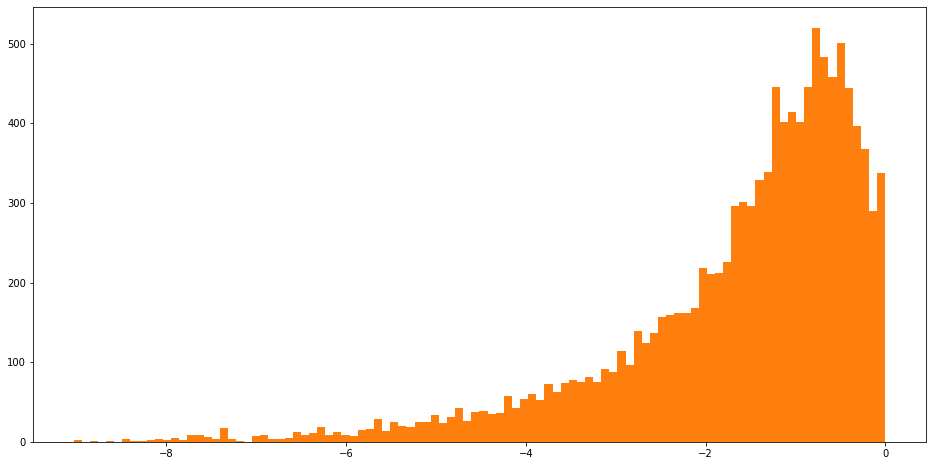

In [ ]:
g = glist[0]
cg = take_giant_component(g)
weights = list(nx.get_edge_attributes(cg,'weight').values())

fig, ax = plt.subplots(figsize = (16,8))
ax.hist(sorted(np.log(np.array(weights)+1e-10))[:], bins = 100)
ax.hist(sorted(np.log(np.array(weights)+1e-10))[:], bins = 100)
ax.hist(sorted(np.log(np.array(weights)+1e-10))[:], bins = 100)

KeyboardInterrupt: ignored

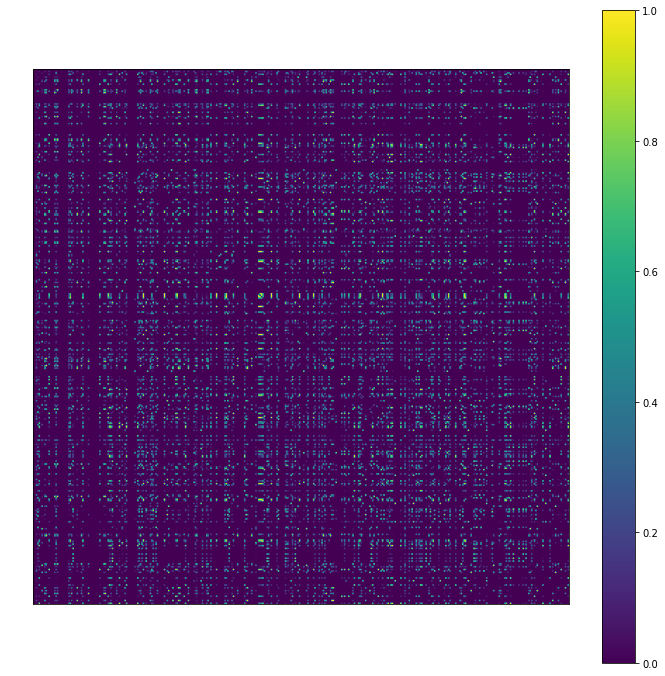

In [ ]:
#@title Single start { form-width: "300px" }
#name = 'sbm'
#kwargs = {'ncl':10, 'rs': 1}

name = 'mouse'
kwargs = {'start':1000, 'vel_thr':0, 'norm':0}

#name = 'er'
#kwargs = {}

#metrics = ['silhouette', 'ch_score', 'db_score']
metrics = ['ch_score']
cl_list = list(range(2,20))

N = 1000
D = Dataset(name, N, **kwargs)
plot_mat(D.data)

matlist, loss, loss_error = run_estimation(D.data, metrics, cl_list)
ax = plot_loss(loss, loss_error, normalize_loss=0)
opt_ncl = find_optimum_ncl(metrics, cl_list, loss)
print('best number of clusters =', opt_ncl)
#bestmat = matlist[cl_list.index(opt_ncl)]
#plot_mat(bestmat)
for mat in matlist:
    plot_mat(mat)
'''
D.shuffle()
matlist2, loss2, loss_error2 = run_estimation(D.shuffled, metrics, cl_list)
plot_loss(loss2, loss_error2, ax = ax, normalize_loss=0, dashed = 1)
'''

In [ ]:
#@title Multi start { form-width: "300px" }
name = 'mouse'
kwargs = {'start':100, 'vel_thr':15, 'norm': 1}

metrics = ['ch_score','db_score']
cl_list = list(range(2,11))

N = 500
for i in range(20):
    print('i =', i)
    name = 'mouse'
    kwargs = {'start':1000+i*N//4, 'vel_thr':15, 'norm': 0}
    D = Dataset(name, N, **kwargs)
    matlist, loss, loss_error = run_estimation(D.data, metrics, cl_list)
    opt_ncl = find_optimum_ncl(metrics, cl_list, loss)
    print('best number of clusters =', opt_ncl)
    bestmat = matlist[cl_list.index(opt_ncl)]
    plot_mat(bestmat)
    ax = plot_loss(loss, loss_error, normalize_loss = 0)
    '''
    D.shuffle()
    matlist2, loss2, loss_error2 = run_estimation(D.shuffled, metrics, cl_list)
    plot_loss(loss2, loss_error2, ax = ax, normalize_loss = 0, dashed = 1)
    bestmat2 = matlist2[cl_list.index(opt_ncl)]
    plot_mat(bestmat2)
    '''

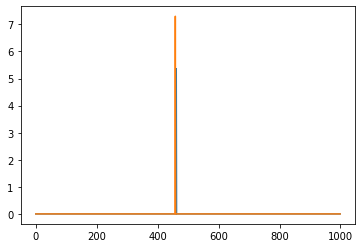

In [ ]:
dataname = 'CA1_'+str(22)+'_HT'+str(1)

picklefile = open(join(PATH,dataname), 'rb')
ms = pickle.load(picklefile)
picklefile.close()

indices_to_take = np.where(ms.v > 0)[0]
d = ms.spikes.T[ms.pc_mask, :]
data = d[:,indices_to_take][:,2000:3000]
#scaler = MinMaxScaler()
#data = scaler.fit_transform(data.T).T
plt.plot(data[0,:])
plt.plot(data[32,:])

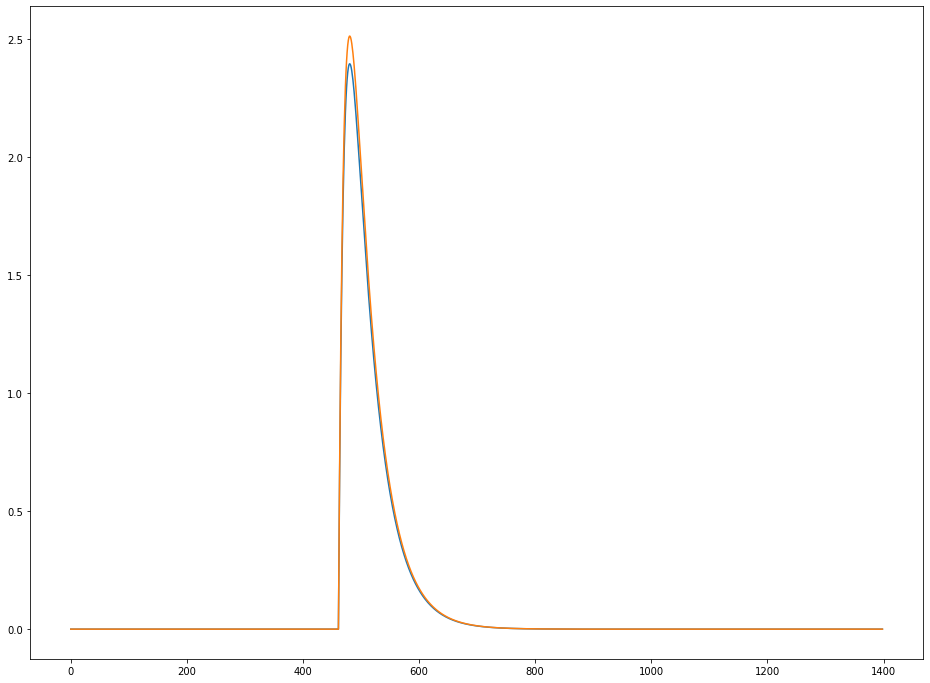

In [ ]:
T_RISE = 15
T_OFF = 40

def spike_form(t):
    return (1-np.exp(-t/T_RISE))*np.exp(-t/T_OFF)

x = np.linspace(0, 400, num = 400)
sp = spike_form(x)

y1 = np.convolve(data[0,:], sp)
y2 = np.convolve(data[106,:], sp)
fig, ax = plt.subplots(figsize = (16,12))
#ax.plot(x,sp)
ax.plot(y1)
ax.plot(y2)

In [ ]:
y1 = np.convolve(data[4,:], sp)
y2 = np.convolve(data[200,:], sp)
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(y1)
ax.plot(y2)
similarity = np.dot(y1,y2)/(np.dot(y1,y1)*np.dot(y2,y2))
print(similarity)

100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


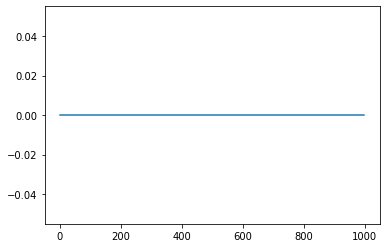

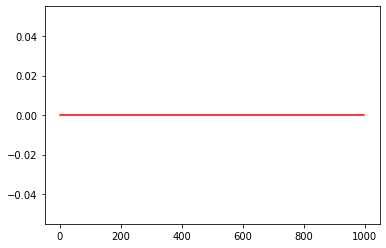

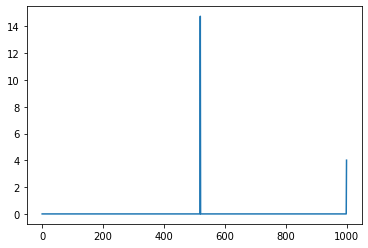

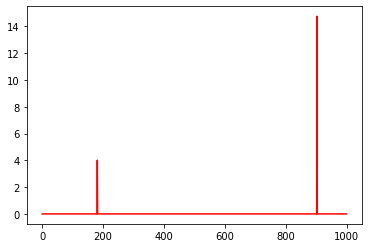

In [ ]:
sim = []
sh_sim = []
for i in tqdm.tqdm(range(len(data))[10:12], leave = True, position = 0):
    d1 = data[i,:]
    plt.figure()
    plt.plot(d1)
    sh_d1 = d1.copy()

    np.random.shuffle(sh_d1)
    plt.figure()
    plt.plot(sh_d1, c = 'r')
    y1 = np.convolve(d1, sp)
    sh_y1 = np.convolve(sh_d1, sp)

    for j in range(len(data)):
        d2 = data[j,:]
        sh_d2 = d2.copy()
        np.random.shuffle(sh_d2)
        y2 = np.convolve(d2, sp)
        sh_y2 = np.convolve(sh_d2, sp)

        similarity = np.dot(y1,y2)/np.sqrt(np.dot(y1,y1)*np.dot(y2,y2))
        sh_similarity = np.dot(sh_y1,sh_y2)/np.sqrt(np.dot(sh_y1,sh_y1)*np.dot(sh_y2,sh_y2))
        sim.append(similarity)
        sh_sim.append(sh_similarity)

#plt.hist(sim)

(array([1.0448e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 1.1000e+01, 2.7000e+01, 7.0000e+00, 1.2000e+01,
        4.6000e+01, 5.1000e+01, 6.1000e+01, 1.0800e+02, 9.7000e+01,
        1.2900e+02, 1.8800e+02, 2.6500e+02, 3.1100e+02, 5.0200e+02,
        6.6200e+02, 8.2400e+02, 9.3800e+02, 1.0610e+03, 1.1750e+03,
        1.2870e+03, 1.3070e+03, 1.4350e+03, 1.5560e+03, 1.6440e+03,
        1.8760e+03, 2.1390e+03, 2.3430e+03, 2.6480e+03, 2.9340e+03,
        3.4050e+03, 3.7300e+03, 4.1230e+03, 4.2910e+03, 2.6450e+03]),
 array([-1.00000000e+01, -9.80000000e+00, -9.60000000e+00, -9.40000000e+00,
        -9.20000000e+00, -9.00000000e+00, -8.80000000e+00, -8.60000000e+00,
        -8.40000000e+00, -8.20000000e+00, -8.00000000e+00, -7.80000000e+00,
        -7.60000000e+00, -7.40000000e+00, -7.20000000e+00, -7.00000000e+00,
        -6.800

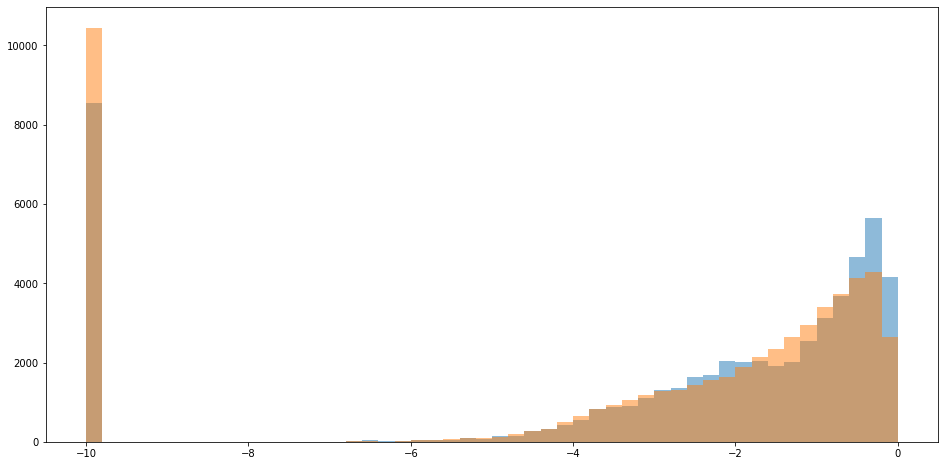

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
ax.hist(np.log10(np.array(sim)+1e-10), bins = 50, alpha = 0.5)
ax.hist(np.log10(np.array(sh_sim)+1e-10), bins = 50, alpha = 0.5)

#ax.hist(np.array(sim), bins = 100)
#ax.hist(np.array(sh_sim), bins = 100)

In [ ]:
print(sim[:100])
print(sh_sim[:100])

[0.0, 1.1438759073871512e-06, 3.155439302204626e-06, 3.727857775125322e-05, 8.978889753931326e-06, 5.1127106292409755e-06, 9.455861104762211e-05, 1.7823483427986738e-07, 1.2342908426871436e-05, 6.175180488461739e-09, 2.069416698241106e-06, 8.450762769372667e-06, 1.9392064168103124e-06, 2.2627875442086592e-05, 1.562924967443762e-05, 1.7162632598195815e-08, 1.7959136904877146e-05, 1.1383884010957256e-05, 2.3952332130004625e-06, 6.694325292933026e-05, 5.02320048194808e-07, 0.0, 0.0, 0.0, 4.829024848737246e-05, 1.1064618822298513e-05, 0.0, 9.209651841648349e-07, 1.403931520617782e-09, 1.6596782266297263e-05, 0.0, 1.6296982784781678e-06, 3.5908736035020668e-06, 1.802305023151662e-07, 0.0, 2.6621463853718363e-05, 2.474180694883619e-06, 2.8161768005180217e-05, 5.225226208220863e-06, 7.379096056084108e-06, 0.0, 0.0, 7.766075980605027e-06, 2.581677254236378e-06, 2.1686404994771275e-08, 4.504628781772342e-08, 0.0, 0.0, 3.266949843212857e-05, 4.989730572143633e-10, 5.0691280098687753e-05, 1.23434